In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils
import PODutils
import math
from scipy import optimize

### Load some data to start

In [2]:
PIVutils = reload(PIVutils)
#X, Y, U, V, Swirl = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/Heat Flux Data/Processed Results/N/Neutral45_2.mat',['X','Y','U','V','Swirl'],[])
#X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/Heat Flux Data/Processed Results/N/Neutral45.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])
X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [3]:
X = X/Cond["delta"]
Y = Y/Cond["delta"]

In [4]:
frame = 0

In [5]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

# See if can match model with minimize

In [6]:
#Create x and y field (Must be centered on zero!!!!!)

BoxSize = 10

Xfull = X;
Yfull = Y;

x = X[0,0:BoxSize+1]
y = Y[0:BoxSize+1,0]

x = x-x[0]
x2 = np.flipud(x)
y = y-y[0]
y2 = np.flipud(y)

x = np.concatenate((-1*x2, x[1:]))
y = np.concatenate((-1*y2, y[1:]))

x[BoxSize] = 0
y[BoxSize] = 0

del x2, y2

X, Y = np.meshgrid(x, y)

In [7]:
reload(PIVutils)

Circ = 0.4
r = 0.03
rs = 0.08
Ts = 200
Rot = 45
StagStren = 2
Gvort = 0.015
Gstag = 0.015
Conv = 0

[Usim, Vsim] = PIVutils.genHairpinField(BoxSize,Circ,r,rs,Ts,Rot,StagStren,Gvort,Gstag,Conv,x=x,y=y)

(-0.15000000000000002,
 0.15000000000000002,
 -0.15000000000000002,
 0.15000000000000002)

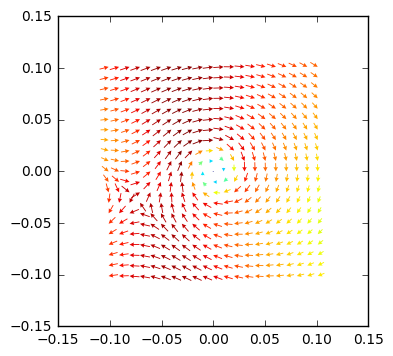

In [8]:
plt.figure()
M = np.hypot(Usim, Vsim)
Q = plt.quiver(X, Y, Usim, Vsim, M, units='x', pivot='tip',headwidth=5, scale=200)
plt.axis('scaled')

In [9]:
Uinit = Usim
Vinit = Vsim

# Check if minimize function can find the same parameters

#### Create target, initial guess and bounds vectors

In [10]:
target = [Circ,r,rs,Ts,Rot,StagStren,Gvort,Gstag,Conv]

In [11]:
init = target*np.random.rand(9);
init[2] = 0.06
init[3] = 180
init[4] = 35
#init[5] = 
#init[8] = init[8]+np.random.rand(1)

In [12]:
x[1]-x[0]

0.010118516377207676

In [13]:
bounds = [(0, None), (x[1]-x[0],np.max(x)), (x[1]-x[0],np.max(x)),\
          (170,280),(0,90),(0,2*Usim.max()),\
          (x[1]-x[0],np.max(x)),(x[1]-x[0],np.max(x)),(-1*Cond["Uinf"]/10, Cond["Uinf"]/10)]

#### Noise up the Data

In [15]:
NoiseFac = 1

Usim = Uinit+NoiseFac*np.random.randn(*Usim.shape)
Vsim = Vinit+NoiseFac*np.random.randn(*Usim.shape)

#### Find minimized difference

In [16]:
reload(PODutils)

#data = PODutils.model(5, 7)
#match = optimize.minimize(PODutils.minfuncVecField, x0=init, args=(U,V,x,y),\
#                          options={'maxiter':10000, 'disp': True}) #'gtol': 1e-6,
match = optimize.minimize(PODutils.minfuncVecField, x0=init, args=(Usim,Vsim,x,y) ,bounds=bounds,\
                          options={'maxiter':10000, 'disp': True}) #'gtol': 1e-6,
#, method='TNC'

match.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [17]:
match.x

array([  3.89612238e-01,   2.89212221e-02,   8.15310959e-02,
         2.00761019e+02,   4.48956003e+01,   2.02016279e+00,
         3.75138883e-02,   3.90789419e-02,   2.07945768e-02])

In [18]:
target

[0.4, 0.03, 0.08, 200, 45, 2, 0.015, 0.015, 0]

In [19]:
(match.x-target) 
# problems with rs, Ts, StagStren

array([-0.01038776, -0.00107878,  0.0015311 ,  0.76101948, -0.10439967,
        0.02016279,  0.02251389,  0.02407894,  0.02079458])

In [20]:
(match.x-target)/target*100

array([  -2.59694039,   -3.59592617,    1.91386983,    0.38050974,
         -0.23199927,    1.00813954,  150.09258868,  160.52627945,
                 inf])

In [21]:
[U2, V2] = PIVutils.genHairpinField(BoxSize,match.x[0],match.x[1],match.x[2],match.x[3],match.x[4],\
                                    match.x[5],match.x[6],match.x[7],match.x[8],x=x,y=y)

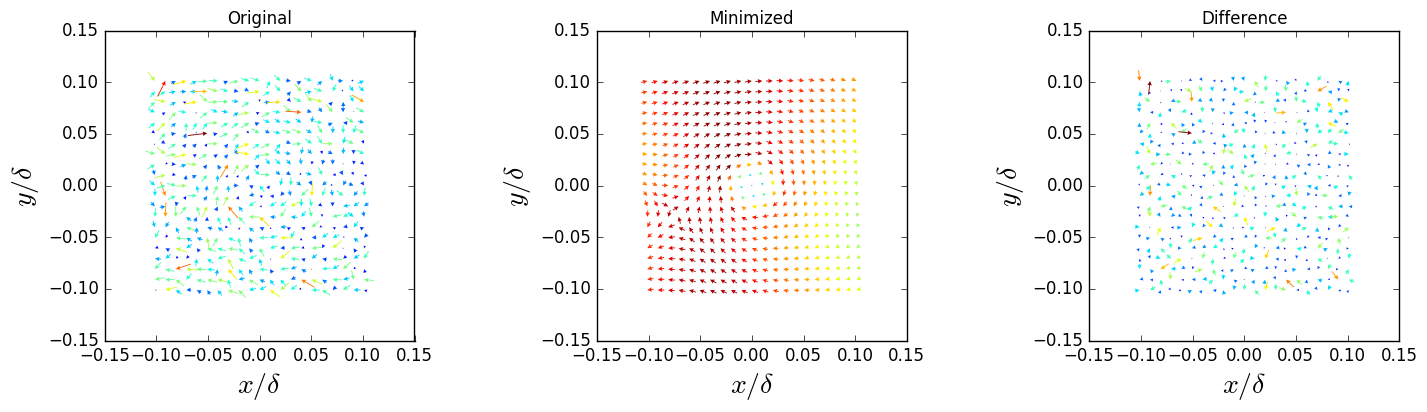

In [22]:
plt.figure()

f, ax = plt.subplots(1,3)
f.set_figwidth(18)

M = np.hypot(Usim-match.x[-1], Vsim)
im1 = ax[0].quiver(X, Y, Usim-match.x[-1], Vsim, M, units='x', pivot='tip',headwidth=5, scale=300)

M = np.hypot(U2-match.x[-1], V2)
im1 = ax[1].quiver(X, Y, U2-match.x[-1], V2, M, units='x', pivot='tip',headwidth=5, scale=300)

M = np.hypot(Usim-U2, Vsim-V2)
im1 = ax[2].quiver(X, Y, Usim-U2, Vsim-V2, M, units='x', pivot='tip',headwidth=5, scale=300)

ax[0].set_title('Original')
ax[0].set_aspect('equal')
#ax[0].set_xlim([X.min(),X.max()])
ax[0].set_ylabel('$y/\delta$', fontsize=20)
ax[0].set_xlabel('$x/\delta$', fontsize=20)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

ax[1].set_title('Minimized')
ax[1].set_aspect('equal')
#ax[1].set_xlim([X.min(),X.max()])
ax[1].set_ylabel('$y/\delta$', fontsize=20)
ax[1].set_xlabel('$x/\delta$', fontsize=20)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

ax[2].set_title('Difference')
ax[2].set_aspect('equal')
#ax[2].set_xlim([X.min(),X.max()])
ax[2].set_ylabel('$y/\delta$', fontsize=20)
ax[2].set_xlabel('$x/\delta$', fontsize=20)
ax[2].tick_params(axis='x', labelsize=12)
ax[2].tick_params(axis='y', labelsize=12)

# Now attempt to match to a real vector field thumbnail

### Remove background noise

In [23]:
Noise = np.std(Swirl,axis=(2,1))
Noise = np.std(Noise[-5:])
print(Noise)

0.243960186268


In [24]:
SwirlFilt = Swirl.copy()    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(Swirl)<20*Noise] = 0

### Normalize field by std

In [25]:
SwirlStd = np.std(Swirl,axis=(2,1))
#print(SwirlStd)

In [26]:
#Normalize field by the std of Swirl
SwirlFilt = SwirlFilt/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

In [27]:
SwirlFiltBackup = SwirlFilt.copy()

### Create thresholded field

In [28]:
SwirlFilt = SwirlFiltBackup.copy()    #think this should completely copy the list, allowing me to try things

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 1.5
SwirlFilt[np.absolute(SwirlFilt)<ThreshSTD] = 0
SwirlFiltPro = SwirlFilt.copy()
SwirlFiltPro[SwirlFiltPro>0] = 0
SwirlFiltRet = SwirlFilt.copy()
SwirlFiltRet[SwirlFiltRet<0] = 0

### Find all blobs and filter for size

In [29]:
BoxSize = 10

PIVutils = reload(PIVutils)
ThreshPro = 35    #30 or 35 cause bug
[num_features_Pro,features_per_frame_Pro, labeled_array_Pro, cent_Pro] = PIVutils.findBlobs(SwirlFiltPro,ThreshPro,EdgeBound = BoxSize)

ThreshRet = 20    #30 or 35 cause bug
[num_features_Ret,features_per_frame_Ret, labeled_array_Ret, cent_Ret] = PIVutils.findBlobs(SwirlFiltRet,ThreshRet,EdgeBound = BoxSize)

There are  76730  features identified
A total of  13188  are larger than the threshold size
Of these 10645  are far enough away from edge of domain
There are  27229  features identified
A total of  3924  are larger than the threshold size
Of these 3489  are far enough away from edge of domain


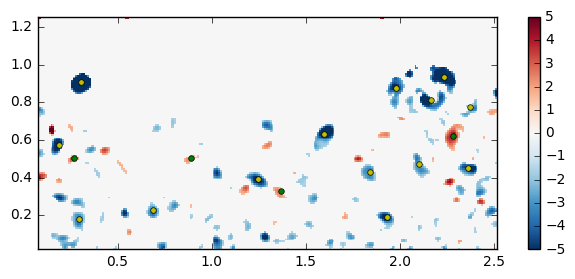

In [30]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],Xfull,Yfull,5)

for i in range(features_per_frame_Pro[frame]):
    plt.plot(cent_Pro[frame][i][1]*scale+Xfull[1,1],cent_Pro[frame][i][0]*scale+Yfull[1,1],'oy',markersize=4,markeredgecolor=None)
    
for i in range(features_per_frame_Ret[frame]):
    plt.plot(cent_Ret[frame][i][1]*scale+Xfull[1,1],cent_Ret[frame][i][0]*scale+Yfull[1,1],'og',markersize=4,markeredgecolor=None)
    
#f.savefig(saveFolder + '/Swirl_5.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Get thumbnails (Box = 21x21)

In [34]:
reload(PIVutils)

Ut, Vt, St= PIVutils.getThumbnails2D(U,V,Swirl,cent_Pro,BoxSize)
#Ut2, Vt2, St2 = PIVutils.getThumbnails2D(U,V,Swirl,cent_Ret,BoxSize)

### Subtract mean mean at centroid of swirl blob

In [35]:
#Calculate mean velocity profiles
Umean = np.nanmean(U,axis=(2,1))
Umean
Umean.shape
#print(Umean)

#Y[cent_Pro[i][j][0]
  
#Now get the thumbnails
thumb = 0
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        Ut[:,:,thumb] = Uf[:,:,thumb]-Umean[cent_Pro[i][j][0]]
        thumb+=1
del Umean

#### Look at sample thumbnail field

In [36]:
vort = 0

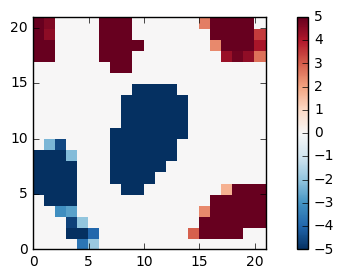

In [37]:
[f, ax] = PIVutils.plotScalarField(St[:,:,vort],bound=5)

(-0.15000000000000002,
 0.15000000000000002,
 -0.15000000000000002,
 0.15000000000000002)

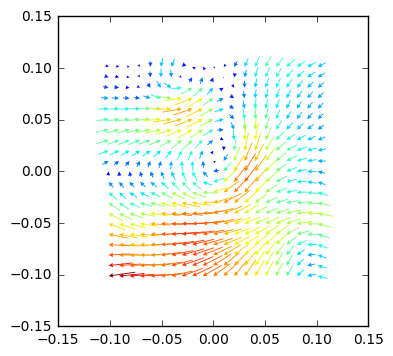

In [38]:
plt.figure()
M = np.hypot(Ut[:,:,vort], Vt[:,:,vort])
Q = plt.quiver(X, Y, Ut[:,:,vort], Vt[:,:,vort], M, units='x', pivot='tip',headwidth=5, scale=10)
plt.axis('scaled')

In [51]:
reload(PODutils)

#match = optimize.minimize(PODutils.minfuncVecField, x0=init, args=(Ut[:,:,vort],Vt[:,:,vort],xsub,ysub))

match = optimize.minimize(PODutils.minfuncVecField, x0=target, args=(Ut[:,:,vort],Vt[:,:,vort],x,y), bounds=bounds, \
                           method='TNC',options={'maxiter':10000,'gtol': 1, 'disp': True}) #
#

match.message

'Local minimum reached (|pg| ~= 0)'

In [52]:
match

     fun: 2.7396219587976463
     jac: array([  6.11069506e-01,  -3.75703824e-01,  -3.15470405e-01,
         4.26991775e-04,  -1.86362037e-03,  -1.02355591e-01,
         3.12292237e-01,  -2.35369795e+00,  -4.58455940e-02])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 569
     nit: 92
  status: 0
 success: True
       x: array([  1.36946980e-02,   2.04126036e-02,   2.33737380e-02,
         2.02941177e+02,   5.62830156e+01,   1.89577508e-01,
         9.94851694e-02,   2.10677238e-02,  -6.37841891e-02])

In [53]:
match.x

array([  1.36946980e-02,   2.04126036e-02,   2.33737380e-02,
         2.02941177e+02,   5.62830156e+01,   1.89577508e-01,
         9.94851694e-02,   2.10677238e-02,  -6.37841891e-02])

In [54]:
match.x[-1]/Cond["Uinf"]

array([-0.04112171])

In [55]:
[U2, V2] = PIVutils.genHairpinField(BoxSize,*match.x,x=x,y=y)

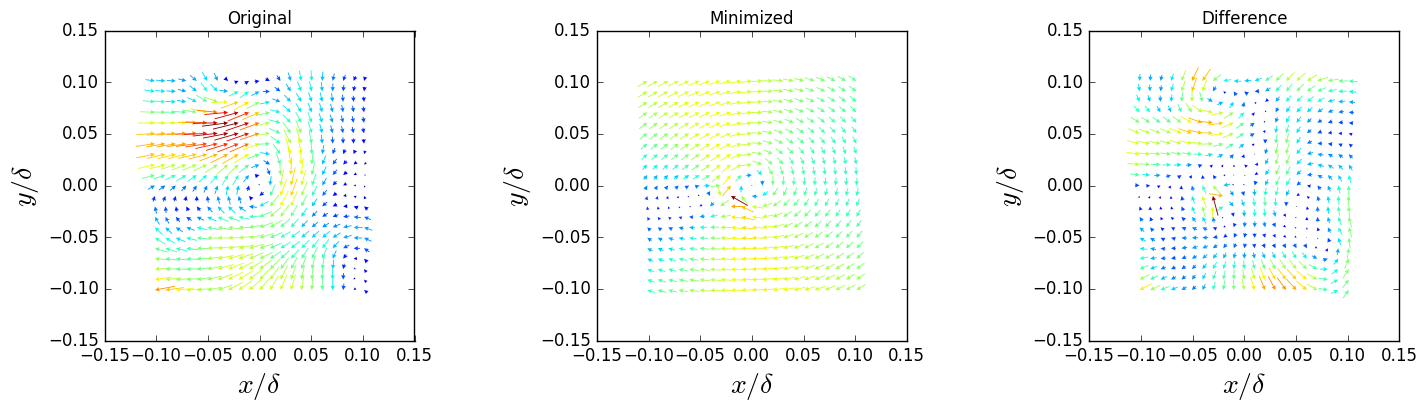

In [56]:
plt.figure()

f, ax = plt.subplots(1,3)
f.set_figwidth(18)

M = np.hypot(Ut[:,:,vort]-match.x[-1], Vt[:,:,vort])
im1 = ax[0].quiver(X, Y, Ut[:,:,vort]-match.x[-1], Vt[:,:,vort], M, units='x', pivot='tip',headwidth=5, scale=10)

M = np.hypot(U2-match.x[-1], V2)
im1 = ax[1].quiver(X, Y, U2-match.x[-1], V2, M, units='x', pivot='tip',headwidth=5, scale=10)

M = np.hypot(Ut[:,:,vort]-U2, Vt[:,:,vort]-V2)
im1 = ax[2].quiver(X, Y, Ut[:,:,vort]-U2, Vt[:,:,vort]-V2, M, units='x', pivot='tip',headwidth=5, scale=10)

ax[0].set_title('Original')
ax[0].set_aspect('equal')
#ax[0].set_xlim([X.min(),X.max()])
ax[0].set_ylabel('$y/\delta$', fontsize=20)
ax[0].set_xlabel('$x/\delta$', fontsize=20)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

ax[1].set_title('Minimized')
ax[1].set_aspect('equal')
#ax[1].set_xlim([X.min(),X.max()])
ax[1].set_ylabel('$y/\delta$', fontsize=20)
ax[1].set_xlabel('$x/\delta$', fontsize=20)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

ax[2].set_title('Difference')
ax[2].set_aspect('equal')
#ax[2].set_xlim([X.min(),X.max()])
ax[2].set_ylabel('$y/\delta$', fontsize=20)
ax[2].set_xlabel('$x/\delta$', fontsize=20)
ax[2].tick_params(axis='x', labelsize=12)
ax[2].tick_params(axis='y', labelsize=12)

In [69]:
initFit = match.x

# Do MCMC analysis

In [59]:
import emcee
print(emcee.__version__)

2.2.1


In [73]:
# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 9  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

In [116]:
# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

In [117]:
starting_guesses[0,:]

array([ 0.5488135 ,  0.71518937,  0.60276338,  0.54488318,  0.4236548 ,
        0.64589411,  0.43758721,  0.891773  ,  0.96366276])

In [118]:
starting_guesses = initFit+initFit*starting_guesses*0.01

In [121]:
starting_guesses[3,:]

array([  1.38240675e-02,   2.05191265e-02,   2.34706599e-02,
         2.03478069e+02,   5.67187776e+01,   1.90442266e-01,
         1.00050677e-01,   2.10716824e-02,  -6.41781429e-02])

In [131]:
# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

reload(PODutils)

sampler = emcee.EnsembleSampler(nwalkers, ndim, PODutils.log_posterior, args=[Ut[:,:,vort],Vt[:,:,vort],x,y,bounds])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

CPU times: user 36 s, sys: 260 ms, total: 36.3 s
Wall time: 37 s
done


(-0.15000000000000002,
 0.15000000000000002,
 -0.15000000000000002,
 0.15000000000000002)

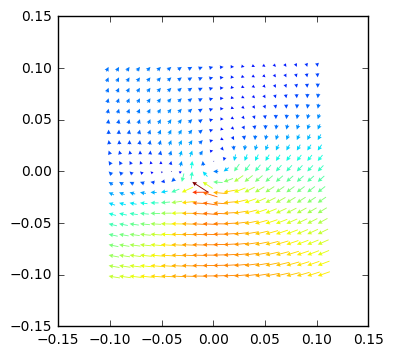

In [125]:
#Debugging stuff

testP = [  2.46364205e+00,   3.93722513e+00,   2.31169339e+00, \
         3.00399917e+00,    9.63049238e-01,   3.24966905e+00, \
         6.77531935e-01,  -3.57512461e-03,   -2.44033508e-01]

testP = [  1.37698563e-02,   2.05585924e-02,   2.35146263e-02,   2.04046969e+02,\
   5.65214613e+01,   1.90801978e-01,   9.99205038e-02,   2.12556001e-02,\
  -6.43988536e-02]

[Utest, Vtest] = PIVutils.genHairpinField(BoxSize,*testP,x=x,y=y)

plt.figure()
M = np.hypot(Utest, Vtest)
Q = plt.quiver(X, Y, Utest, Vtest, M, units='x', pivot='tip',headwidth=5)
plt.axis('scaled')

In [129]:
PODutils.log_posterior(testP, Ut[:,:,vort],Vt[:,:,vort],x,y,bounds)

-2.7392484548194758

#### Look at results of MCMC

In [132]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
#plot_MCMC_results(xdata, ydata, emcee_trace)



NameError: name 'plot_MCMC_results' is not defined

In [134]:
emcee_trace.shape

(9, 50000)

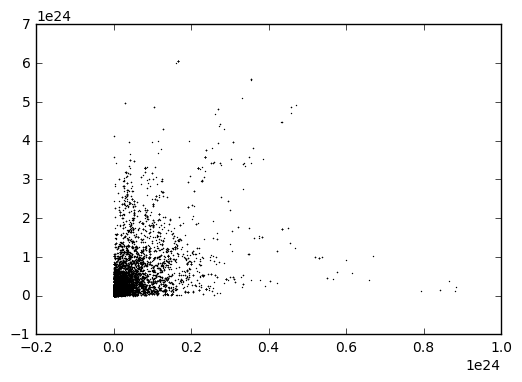

In [145]:
plt.scatter(emcee_trace[0,:],emcee_trace[1,:],s=1,lw = 0,facecolor='k')